## Aiyagari Model (1994)




# Consumer's Problem
$$V(a,l)=\max\big\{ u(c) + \beta E[V(a',l')]  \big\} $$
Subject to $ a'= (1+r)a + w*l - c$ and $a'\geq -\underline{a}$ , where $l_t \in \{0.1, 1, 1.25\}$ and the transition matrix for $l_t$ is $$ \Pi = \begin{bmatrix} 0.5 & 0.4 & 0.1 \\ 0.2 & 0.7 & 0.1 \\ 0.2 & 0.2 & 0.6 \end{bmatrix}.$$  

With parameters 
 - $r = 0.0505$ (interest rate)
 - $w = 0.0560$ (wage rate per efficiency unit of labor)
 - $\underline{a} = 0.1$ (There is an ad hoc borrowing limit)
 - $ \beta = 0.95$ (discount factor)

Compute the value function $V(a, l)$ and the optimal policy function $a' = g(a, l)$, where $a' \geq −\underline{a}$ is the next period’s financial wealth. 

In [39]:
using Parameters, Random
using LinearAlgebra, LaTeXStrings, Plots
using Optim, Distributions
using QuantEcon, Interpolations
using Distributed, Base.Threads
using NLsolve, Dierckx

#theme(:lime)

#theme(:ggplot2) #for plots 
theme(:solarized_light)
Random.seed!(42) # for reproducible results

TaskLocalRNG()

In [40]:
"""
Household Parameters
which define the model

* α: Capital share in output
* β: Discount factor
* r: interest rate
* R: Gross interest rate
* u: utility function
* Π: transition matrix

* z_chain: markov chain of labor productivity
* u: utility function

* a_low: borrowing constraint.
* a_high: top value for the asset grid
* a_size: number of points in the asset grid
* a_vals: Grid over assets = function of a_low, a_high, and a_size

"""
@with_kw mutable struct HouseholdProblem
    
    β::Float64 = 0.95 
    r::Float64 = 0.0505  
    R::Float64 = 1 + r
    w::Float64 = 0.0560
    Π::Matrix{Float64} =   [ 0.5 0.4 0.1 ;
                            0.2 0.7 0.1 ; 
                            0.2 0.2 0.6] 
    z_vals = [0.1; 1.0; 1.25]                         
    z_chain = MarkovChain(Π, z_vals)
    u = u_fun
    
    z_size = length(z_chain.state_values)
    z_p = z_chain.p

    a_low::Float64 = 0.1
    a_high::Float64 =2
    a_size::Int64 = 100
    a_vals::Vector{Float64} = range(-a_low, a_high, length = a_size)
    # n = a_size * l_size
end 


@with_kw mutable struct firmProblem
    z::Float64 = 0.1 
    α::Float64 = 0.3
    δ::Float64 = 0.0
    L::Float64 = 1.0 
end

# for deepcopies of the structure 
Base.copy(x::T) where T = T([deepcopy(getfield(x, k)) for k ∈ fieldnames(T)]...)

In [41]:
function u_fun(c; σ = 1) # utility function to use 

    if (σ == 1 ) 
        arg = log(c)
    else 
        x = maximum([0, c])
        arg = (x^(1 - σ) - 1) / (1 - σ) 
    end 
    return arg
end 

u_fun (generic function with 1 method)

In [42]:
# Bellman Operator: GridSearch 
function T1(v::Matrix{Float64}; p::HouseholdProblem , tol::Float64 = 1e-10)
    @unpack β, R, w, z_chain, u, a_size, a_vals, a_low  = p # unpack parameters
    z_size = length(z_chain.state_values)
    z_vals = z_chain.state_values
    z_p = z_chain.p

    Tv = zeros(size(v)) #Value function values
    policy  = zeros(size(v))  #Policy function values
    c_path = zeros(size(v))  #consumption values

    # For every point on the assets grid:
    for ia in 1:a_size
        # For every state of labor productivity:
        for iz in 1:z_size
            # Compute consumption for all possible a':
            tmp = R*a_vals[ia] + w*z_vals[iz] .- a_vals; #a_sizex1 vector 
            tmp[tmp .> R*a_vals[ia] + w*z_vals[iz] .+ a_low] .= R*a_vals[ia] + w*z_vals[iz] .+ a_low
            tmp_max = -Inf;
            pol_ind_tmp = a_vals[ia];
            # For every possible value of consumption:
            for (j, c) in enumerate(tmp) 
                # If consumption is positive:
                if c > 0
                    # u(c(a, a')) + beta * E[V(A')|l']:
                    tmp_comp = u(c) + β*dot(z_p[iz, :], v[j, :])

                    # Find the max, and save the index for policy:
                    if tmp_comp > tmp_max #if V(a,l) > past V(a,l): save value
                        tmp_max = tmp_comp;
                        
                        pol_ind_tmp =  R * a_vals[ia] .+ w*z_vals[iz] - c; #associated policy a'
                    end
                end
            end
            Tv[ia, iz] = tmp_max;
            policy[ia, iz] = pol_ind_tmp;
            c_path[ia, iz] = R * a_vals[ia] .+ w*z_vals[iz] .- policy[ia, iz]
        end
    end

    return (;v = Tv, σ_a = policy, c = c_path) # returns named tuple of results
end 

# Bellman Operator: GridSearch with interpolation
function T2(v::Matrix{Float64}; p::HouseholdProblem , tol::Float64 = 1e-10)
    @unpack β, R, w, z_chain, u, a_size, a_vals, a_low  = p # unpack parameters
    z_size = length(z_chain.state_values)
    z_vals = z_chain.state_values
    z_p = z_chain.p
    z_idx = 1:length(z_vals)


    v_func = interp(a_vals, v) # value function when the shock index is z_i
    Tv = zeros(size(v)) #Value function values
    policy  = zeros(size(v))  #Policy function values
    c_path = zeros(size(v))  #consumption values
    opt_lb = 1e-8

    # For every state of labor productivity: (or given a state z)
    for (iz, z) in enumerate(z_vals)
        # For every point on the assets grid:    
        for (ia, a) in enumerate(a_vals)
            # Compute consumption for all possible a':

            function obj(c)
                # E[V(a',l')]
                EV = dot(z_p[iz, :], v_func.(R * a + w*z - c, z_idx) ) # compute expectation
                return u(c) +  β * EV
            end

            #
            opt_ub = R .* a .+ w*z .+ a_low
            # sometimes I have problems in the border
            if opt_ub < 0
                opt_ub = opt_lb
            end
            # 
            res = Optim.maximize(obj, opt_lb, opt_ub) #maximizing consumption
            Optim.converged(res) || error("Didn't converge") # important to check
           
            c_path[ia, iz] = Optim.maximizer(res) #optimal C
            policy[ia, iz] = R .* a .+ w*z .- c_path[ia, iz] #optimal a'
            Tv[ia, iz]  = Optim.maximum(res) #optimal value
           
        end
    end

    return (;v = Tv, σ_a = policy, c = c_path) # returns named tuple of results
end 

T2 (generic function with 1 method)

In [43]:
# Better than iterations

function solve_household_T1(initial_v; p, iterations = 500, m = 3, show_trace = false) 
    results = fixedpoint(v -> T1(v;p).v, initial_v; iterations, method = :anderson, m, show_trace) # Anderson iteration; wrapper for nlsolve
    v_star = results.zero
    policy_a = T1(results.zero;p).σ_a
    c= T1(results.zero;p).c
    return (;v_star, policy_a, c, results, p = p)
end

function solve_household_T2(initial_v; p, iterations = 500, m = 3, show_trace = false) 
    results = fixedpoint(v -> T2(v;p).v, initial_v; iterations, method = :anderson, m, show_trace) # Anderson iteration; wrapper for nlsolve
    v_star = results.zero
    policy_a = T2(results.zero;p).σ_a
    c= T2(results.zero;p).c
    return (;v_star, policy_a, c, results, p = p)
end

solve_household_T2 (generic function with 1 method)

Converged in 178 to an ||residuals||_∞ of 9.508369203103939e-9
Converged in 178 to an ||residuals||_∞ of 9.508369203103939e-9


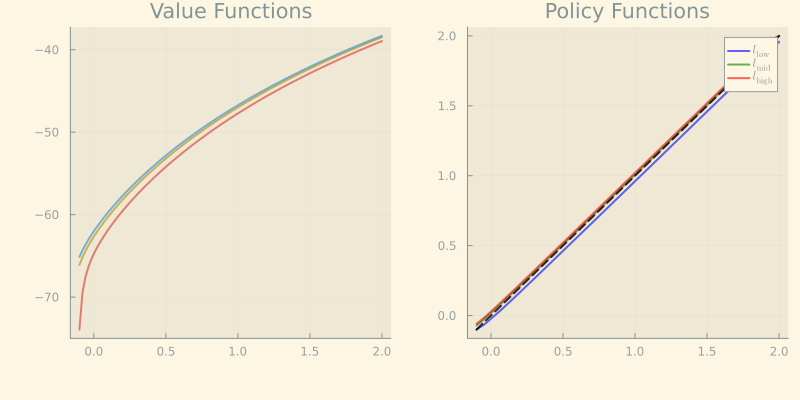

In [44]:
# This is also necessary to run the experiments regarding variations in the borrowing constraint and the interest rate.
p_test = HouseholdProblem()
initial_v = ones(p_test.a_size, p_test.z_size); #An initial guess -- fairly arbitrary
sol = solve_household_T2(initial_v;p= p_test)

v_star_approx = sol.v_star
println("Converged in $(sol.results.iterations) to an ||residuals||_∞ of $(sol.results.residual_norm)")

p1 = plot(title="Value Functions")
plot!(p1, p_test.a_vals, v_star_approx, linewidth = 2, alpha = 0.6,
      label = "")
plot!(p1, legend = :bottomright)

policy_approx = sol.policy_a
println("Converged in $(sol.results.iterations) to an ||residuals||_∞ of $(sol.results.residual_norm)")

p2 = plot(title= "Policy Functions")
plot!(p2, p_test.a_vals, policy_approx[:,1], line = (:blue,0.6,2),
      label = L"$l_{\mathrm{low}}$")
plot!(p2, p_test.a_vals, policy_approx[:,2],line = (:green,0.6,2),
      label = L"$l_{\mathrm{mid}}$")
plot!(p2, p_test.a_vals, policy_approx[:,3],line = (:red,0.6,2),
      label = L"$l_{\mathrm{high}}$")
plot!(p2, p_test.a_vals, p_test.a_vals, linestyle = :dash, color = "black", linewidth = 2, alpha = 0.8, label= "" )

plot!(p2, legend = :bottomright)

plot(p1, p2, layout=(1,2), legend=true, size=(800,400), bottom_margin= 10Plots.mm, left_margin= 7Plots.mm)

In [45]:
"""
This function simulate the state path for any given transition matrix P.
"""
function mc_sample_path(P; init = 1, sample_size = 1000)
    @assert size(P)[1] == size(P)[2] # square required
    N = size(P)[1] # should be square

    # create vector of discrete RVs for each row
    dists = [Categorical(P[i, :]) for i in 1:N]

    # setup the simulation
    X = fill(0, sample_size) # allocate memory, or zeros(Int64, sample_size)
    X[1] = init # set the initial state

    for t in 2:sample_size
        dist = dists[X[t-1]] # get discrete RV from last state's transition distribution
        X[t] = rand(dist) # draw new value
    end
    return X
end

"""
This function simulate the assets series using the transition matrix. This is useful for implementing
computing the stationary distribution of the assets
"""
function compute_asset_series(;p_for_assets, sol, init_cond = 1, T_N = 500_000)
    @unpack Π, z_vals, R, a_vals, w = p_for_assets 
    z_idx = 1:length(z_vals)
    
    cf = interp(p_for_assets.a_vals, sol.c)

    a = zeros(T_N + 1)
    z_seq = mc_sample_path(Π; init = init_cond, sample_size = T_N)
    # note: z_seq is the index of the simulated states (starts at init_cond)
    for t in 1:T_N
        i_z = z_seq[t]
        a[t+1] = R * a[t] + w*z_vals[i_z] - cf(a[t], i_z)
    end
    a_serie = a[2:end] # note: this is a'
    z_serie = z_seq
    return (a_serie, z_serie)
end

"""
Fixing a state forever, compute the stationary serie of assets for all the states.
"""
function compute_asset_series_fixed(;p_for_assets, sol, T_N = 500_000)
    @unpack Π, z_vals, R, a_vals, w = p_for_assets 
    z_idx = 1:length(z_vals)
    
    cf = interp(p_for_assets.a_vals, sol.c)

    a = zeros(T_N + 1, p_for_assets.z_size)
    for (iz, z_val) in enumerate(p.z_vals)
        for t in 1:T_N
            a[t+1, iz] = R * a[t,iz] + w*z_val - cf(a[t,iz], iz)
        end
    end
    return a
end

compute_asset_series_fixed

In [46]:
# To calculate the r* 
"""
Brent's Method for Numerical Analysis: 
From "Numerical Recipes in C: The Art of Scientific Computing, Second Edition" 
"""
function brent(f::Function, x0::Number, x1::Number, args::Tuple=();
    xtol::AbstractFloat=1e-7, ytol=2eps(Float64),
    maxiter::Integer=50)

    EPS = eps(Float64)
    y0 = f(x0,args...)
    y1 = f(x1,args...)
    if abs(y0) < abs(y1)
        # Swap lower and upper bounds.
        x0, x1 = x1, x0
        y0, y1 = y1, y0
    end

    x2 = x0
    y2 = y0
    x3 = x2
    bisection = true
    for _ in 1:maxiter
        # x-tolerance.
        if abs(x1-x0) < xtol
            return x1
        end

        # Use inverse quadratic interpolation if f(x0)!=f(x1)!=f(x2)
        # and linear interpolation (secant method) otherwise.
        if abs(y0-y2) > ytol && abs(y1-y2) > ytol
        x = x0*y1*y2/((y0-y1)*(y0-y2)) +
            x1*y0*y2/((y1-y0)*(y1-y2)) +
            x2*y0*y1/((y2-y0)*(y2-y1))
        else
            x = x1 - y1 * (x1-x0)/(y1-y0)
        end

        # Use bisection method if satisfies the conditions.
        delta = abs(2EPS*abs(x1))
        min1 = abs(x-x1)
        min2 = abs(x1-x2)
        min3 = abs(x2-x3)
        if (x < (3x0+x1)/4 && x > x1) ||
            (bisection && min1 >= min2/2) ||
            (!bisection && min1 >= min3/2) ||
            (bisection && min2 < delta) ||
            (!bisection && min3 < delta)
            
            x = (x0+x1)/2
            bisection = true
        else
            bisection = false
        end

        y = f(x,args...)
        # y-tolerance.
        if abs(y) < ytol
            return x
        end
        x3 = x2
        x2 = x1
        if sign(y0) != sign(y)
            x1 = x
            y1 = y
        else
            x0 = x
            y0 = y
        end
        if abs(y0) < abs(y1)
            # Swap lower and upper bounds.
            x0, x1 = x1, x0
            y0, y1 = y1, y0
        end
    end
    error("Max iteration exceeded")
end

brent

In [47]:
# Aggregate Labor 
"""
Useful to compute the aggregate labor in the economy at the stationary state
"""
function aggregate_labor(transition_matrix, state_values )
    D = zeros(size(transition_matrix))
    # [ev,ed] = eig(pi);
    ev = eigvecs(transition_matrix)
    ed = eigvals(transition_matrix)
    inmax = argmax(real.(ed))
    emax = maximum(real.(ed))
    D[inmax,inmax] = emax
    pinf = ev*D*inv(ev)
    #N = pinf[inmax,inmax]
    N = pinf * state_values
    return (pinf, N)
end 

# from first order condition
"""
From the first order conditions of the firm, we can compute the wage rate at any given r.
"""
function wage_r(r; f)
    # Equilibrium wages associated with a given interest rate r.
    @unpack z, α, δ= f
    value_exp = α / (1 - α)
    renta_rate = r + δ
    return z * (1 - α) * (( (z * α) / renta_rate)^value_exp)
end

# from first order condition
"""
From the first order conditions of the firm, we can compute the interest rate at any given K.
"""
function r_rate(K; f)
    # Inverse demand curve for capital.  The interest rate associated with a
    # given demand for capital K.
    @unpack z, α, δ, L = f
    value_exp = 1 - α
    return z * α * ((L / K)^value_exp) - δ
end

r_rate

In [48]:
"""
Given prices: report the capital equilibrium 
"""
function K_prices(p_market::HouseholdProblem, f_market::firmProblem, r_rate::Float64)
    # println([p2.w p2.r])
    initial_v = ones(p_market.a_size, p_market.z_size); #An initial guess -- fairly arbitrary
    sol = solve_household_T2(initial_v, p = p_market)

    # Compute the stationary distribution
    T_sample = 500_000
    a_t_large = zeros(T_sample, p_market.z_size )
    for j in 1:p_market.z_size
        a_t_large[:,j] , indxz = compute_asset_series(p_for_assets = p_market, sol = sol, init_cond = j, T_N=T_sample)
    end
    # Return K
    return mean(a_t_large[:,:])
end

"""
Compute the market equilibrium: this versions is only useful 
if you want to graph the supply and demand for capital
"""
function market_equilibrium(; p_market::HouseholdProblem, f_market::firmProblem, 
    low_r = 0.025, high_r = 0.1, num_r = 30)

    #Aggregate Labor at stationary eq
    Π_large, L_t_large= aggregate_labor( p_market.Π, p_market.z_vals );

    f_market.L = L_t_large[1]
    
    #r grid 
    r_vals = range(low_r, high_r, length = num_r)

    # Compute supply of capital: given r, wich is the value of capital and wages?
    k_supply = zeros(size(r_vals))
    for (i, r_rate) in enumerate(r_vals)
        
        # wage at r
        wage = wage_r(r_rate, f = f_market) 

        #updating the parameters of the household
        p_market.w = wage 
        p_market.r = r_rate
        p_market.R = 1 + p_market.r 
        
        k_supply[i] = K_prices(p_market, f_market, r_rate)
        # println(k_supply[i])
    end 

    # cheap way of dealing with explosive values
    temp_k = sort(k_supply, rev = true)

    temp = 0 
    for (i, kval) in enumerate(temp_k)
        if kval!=Inf
            temp = kval
            break 
        end 
    end 
    k_supply[(k_supply .== Inf)] .= temp #k(r) supply

    # demand for capital by firms
    k_demand = r_rate.(k_supply, f = f_market) # r(k)

    # cheap way to get the intersection
    n = length(r_vals)
    spl_1 = Spline1D(k_supply, (k_demand .- r_vals).^2)
    x0 = roots(spl_1)  
    # y0 = Spline1D(1:n,  r_vals)(x0[1]) 

    # r, w, and k at optimum
    k_star = x0[1];
    r_star = r_rate.(k_star, f = f_market)
    #r_star =y0[1];
    eq_sol = [r_star wage_r(r_star; f = f_market) k_star];
    

    return (eq_sol, k_supply, k_demand, r_vals)
end 

"""
Compute the market equilibrium: this versions is only useful 
if you want to compute the equilibrium. It is slow. 
"""
function market_equilibrium2(; p_market::HouseholdProblem, f_market::firmProblem, 
    low_r = 0.025, high_r = 0.1, num_r = 30)

    #Aggregate Labor at stationary eq
    Π_large, L_t_large= aggregate_labor( p_market.Π, p_market.z_vals );

    f_market.L = L_t_large[1]
    
    #r grid 
    r_vals = range(low_r, high_r, length = num_r)

    # Compute supply of capital: given r, wich is the value of capital and wages?  
    k_demand_save = 0.0  
    for (i, r_i) in enumerate(r_vals)
        
        # wage at r
        wage = wage_r(r_i, f = f_market) 

        #updating the parameters of the household
        p_market.w = wage 
        p_market.r = r_i
        p_market.R = 1 + p_market.r 
        
        k_supply = K_prices(p_market, f_market, r_i)

        # demand for capital by firms
        k_demand = r_rate.(k_supply, f = f_market) # r(k)

        if k_demand - r_i< 0
            println("OK: $i")
            low_r = k_demand
            high_r = r_i
            break 
        end 
    end 

    println([low_r high_r])
    r_vals = range(low_r, high_r, length = Int16(num_r*0.5))
    k_star = Float64[]
    k_supply_save =0.0
    for (i, r_i) in enumerate(r_vals)
        
        # wage at r
        wage = wage_r(r_i, f = f_market) 

        #updating the parameters of the household
        p_market.w = wage 
        p_market.r = r_i
        p_market.R = 1 + p_market.r 
        
        k_supply = K_prices(p_market, f_market, r_i)

        # demand for capital by firms
        k_demand = r_rate.(k_supply, f = f_market) # r(k)

        if k_demand - r_i< 0
            println("OK: $i")
            push!(k_star, k_supply_save)
            break 
        end 

        k_supply_save = k_supply
    end

    r_star = r_rate.(k_star[1], f = f_market)
    #r_star =y0[1];
    eq_sol = [r_star wage_r(r_star; f = f_market) k_star[1]];
    

    return eq_sol
end 

"""
Compute the market equilibrium. This versions is only useful 
if you want to compute the equilibrium. It is much faster and we don't require to establish a grid for r. 
"""
function market_equilibrium3(; p_market::HouseholdProblem, f_market::firmProblem, 
    low_r = 0.025, high_r = 0.1)

    #Aggregate Labor at stationary eq
    Π_large, L_t_large= aggregate_labor( p_market.Π, p_market.z_vals );

    f_market.L = L_t_large[1]
    
    # Compute supply of capital: given r, wich is the value of capital and wages?  
    function f_star(r_i, p_market, f_market)
        # wage at r
        wage = wage_r(r_i, f = f_market) 

        #updating the parameters of the household
        p_market.w = wage 
        p_market.r = r_i
        p_market.R = 1 + p_market.r 
        
        k_supply = K_prices(p_market, f_market, r_i)

        # demand for capital by firms
        k_demand = r_rate.(k_supply, f = f_market) # r(k)
        return k_demand-r_i
    end 

    r_star = brent(r_i->f_star(r_i, p_market, f_market), low_r,high_r)

    k_star = K_prices(p_market, f_market, r_star)


    eq_sol = [r_star wage_r(r_star; f = f_market) k_star];
    

    return eq_sol
end 

market_equilibrium3

Converged in 178 to an ||residuals||_∞ of 9.508369203103939e-9
Converged in 178 to an ||residuals||_∞ of 9.508369203103939e-9


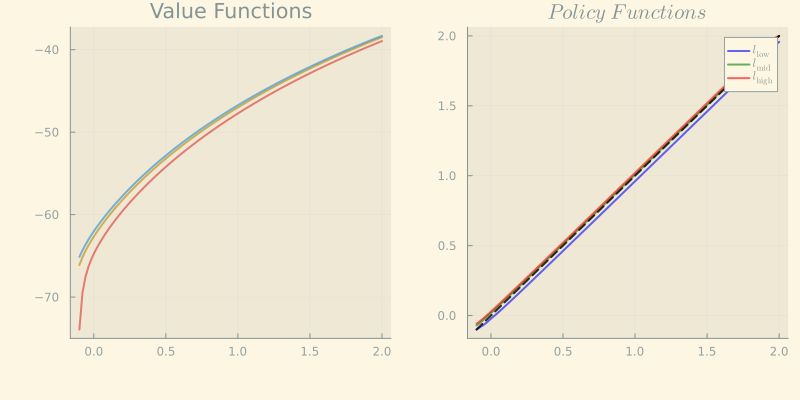

In [49]:
# a look to the value and policy function before starting
p = HouseholdProblem()
initial_v = ones(p.a_size, p.z_size); #An initial guess -- fairly arbitrary
sol = solve_household_T2(initial_v;p)

v_star_approx = sol.v_star
println("Converged in $(sol.results.iterations) to an ||residuals||_∞ of $(sol.results.residual_norm)")

p1 = plot(title="Value Functions")
plot!(p1, p.a_vals, v_star_approx, linewidth = 2, alpha = 0.6,
      label = "")
plot!(p1, legend = :bottomright)

policy_approx = sol.policy_a
println("Converged in $(sol.results.iterations) to an ||residuals||_∞ of $(sol.results.residual_norm)")

p2 = plot(title=L"Policy\ Functions")
plot!(p2, p.a_vals, policy_approx[:,1], line = (:blue,0.6,2),
      label = L"$l_{\mathrm{low}}$")
plot!(p2, p.a_vals, policy_approx[:,2],line = (:green,0.6,2),
      label = L"$l_{\mathrm{mid}}$")
plot!(p2, p.a_vals, policy_approx[:,3],line = (:red,0.6,2),
      label = L"$l_{\mathrm{high}}$")
plot!(p2, p.a_vals, p.a_vals, linestyle = :dash, color = "black", linewidth = 2, alpha = 0.8, label= "" )

plot!(p2, legend = :bottomright)

plot(p1, p2, layout=(1,2), legend=true, size=(800,400), bottom_margin= 10Plots.mm, left_margin= 7Plots.mm)

## Q0: 

How does the optimal policy function change in response to changes in the borrowing limit or the interest rate?

To respond that question, we compute the household problem with variations in the borrowing constraint and the interest rate

In [50]:

#plot_array = Any[]

saveResults = Any[]
a_low_vals = [0.1 0.5 2]
for (i, a_low_val) in enumerate(a_low_vals)
    p_tem = HouseholdProblem(a_low = a_low_val)
    initial_v = ones(p_tem.a_size, p_tem.z_size); #An initial guess -- fairly arbitrary
    sol = solve_household_T2(initial_v; p = p_tem)
    policy_approx = sol.policy_a

    #=
    g = plot()
    for (j , l_vals) in enumerate(p_tem.z_vals)
      plot!(g, p_tem.a_vals, policy_approx[:,j], linewidth = 2, alpha = 0.6,
        label = L"l=%$l_vals, a=%$a_low_val", xlabel = "Current Assets", ylabel = "Next Period Assets")
      plot!(g, legend = :bottomright)
    end 
    push!(plot_array, g)
    =#
    push!(saveResults, sol) 
end 

#plt = plot(plot_array...,layout=(1,3),size=(1600,800), plot_title = "Policy Functions", bottom_margin= 10Plots.mm, left_margin= 7Plots.mm)


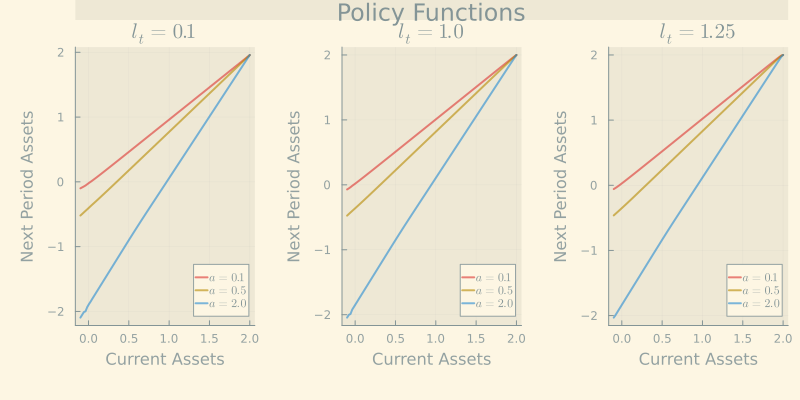

In [51]:
p = HouseholdProblem()
plot_array = Any[]
for (j , l_vals) in enumerate(p.z_vals)
    g = plot(bottom_margin= 10Plots.mm, left_margin= 7Plots.mm)
    for (i, a_low_val) in enumerate(a_low_vals)
        plot!(g, p.a_vals, saveResults[i].policy_a[:,j], linewidth = 2, alpha = 0.6,
            label = L"a=%$a_low_val", xlabel = "Current Assets", ylabel = "Next Period Assets", title = L"l_t=%$l_vals")
        plot!(g, legend = :bottomright)
    end
    push!(plot_array, g)
end 

plt = plot(plot_array...,layout=(1,3),size=(800,400), plot_title = "Policy Functions")


From here we can see that if we make the maximum amount that the person can borrow larger, we have that at any given $a_t$ the optimal $a_{t+1}^*$ is smaller than the case where $\underline{a} =0.1$. In other words, the individuals are going to take the option of borrowing larger amounts to consume more. 

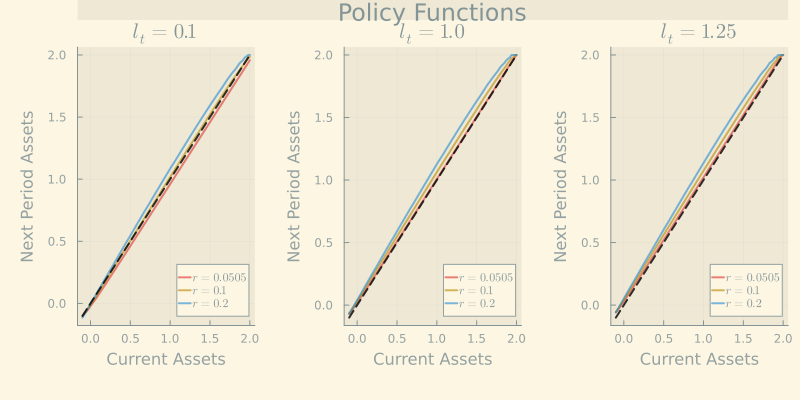

In [52]:
# Changin r
plot_array = Any[]

saveResults_r = Any[]
r_vals = [0.0505 0.1 0.2]
for (i, r_val) in enumerate(r_vals)
    p_tem = HouseholdProblem(r = r_val)
    initial_v = ones(p_tem.a_size, p_tem.z_size); #An initial guess -- fairly arbitrary
    sol = solve_household_T2(initial_v;p = p_tem)

    push!(saveResults_r, sol) 
end 

plot_array = Any[]
for (j , l_vals) in enumerate(p.z_vals)
    g = plot()
    for (i, r_val) in enumerate(r_vals)
        plot!(g, p.a_vals, saveResults_r[i].policy_a[:,j], linewidth = 2, alpha = 0.6,
            label = L"r=%$r_val", xlabel = "Current Assets", ylabel = "Next Period Assets", title = L"l_t=%$l_vals")
        plot!(g, legend = :bottomright)
    end
    plot!(g, p.a_vals, p.a_vals, linestyle = :dash, color = "black", linewidth = 2, alpha = 0.8, label= "" )
    push!(plot_array, g)
end 

plt = plot(plot_array...,layout=(1,3),size=(800,400), plot_title = "Policy Functions",bottom_margin= 10Plots.mm, left_margin= 7Plots.mm)

In the other hand, if we increase the interest rate, we are going to see that now the optimal $a_{t+1}^*$ is greater than or equal to $a_{t}$ (in most of the cases) which means that is going to consume less in period $t$. The only spacial case is when we have $r=0.0505$ and $l=0.1$, in that case the individual "eats" part of its assets to sustain consumption.  

## EQUILIBRIUM

Firms maximize profits $$\max\limits_{K_t, L_t} zK_t^\alpha L_t^{1-\alpha} - (r+\delta)K_t - L_t. $$ where $(r+\delta)$ is the rental rate of capital (here $\delta = 0$). Given this, the optimal value for $w$ given $r$ is $$w=z(1-\alpha)\left(\frac{z\alpha}{r+\delta}\right)^{\frac{\alpha}{1-\alpha}} $$ Then, given $K^*$ we can compute the optimal value of $r$, $$r = z\alpha \left(\frac{L}{K}\right)^{1-\alpha}$$

$\Pi^{T} l_t $ where $T$ is large enough to produce $\Pi^{T}  l^* = l^*$

## Starionary Equilibrium

There is a representative firm in the economy, with a CRS production function $Y = zK^{\alpha}L^{1-\alpha}$. Assume that capital does not depreciate: $\delta = 0$. Now assume $z = 0.1$ and $\alpha = 0.3$.

### Q1: 
Compute the equilibrium $r$ and $w$. Plot the invariant distribution of wealth conditioning on each of the three $l$. Also plot the optimal consumption choice as a function of $a$ and $l$.

> Note: we are going to use this equilibrium as our benchmark model.

eq_plt_1 = Plot{Plots.GRBackend() n=3}


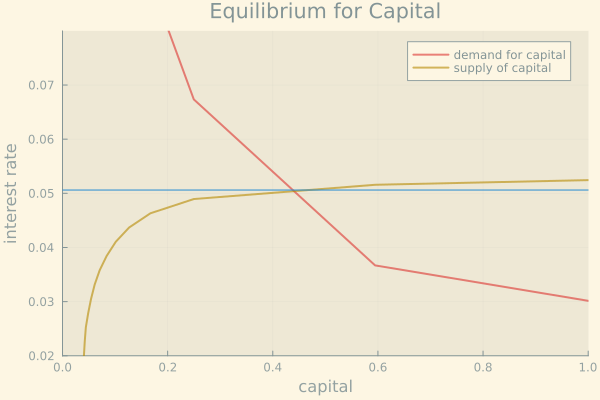

In [53]:
# Create an instance of Household and firm: testing purpose
#=
p_initial = HouseholdProblem(β = 0.96, a_high = 20, a_size = 50,
            Π = [0.9 0.1; 0.1 0.9], z_vals=[0.1; 1.0], a_low=1e-10, 
            w = 1.0, r = 0.01 )
f_initial = firmProblem(z = 1, α = 0.33, δ = 0.05, L = 1)
=#

p_initial = HouseholdProblem()
f_initial = firmProblem()

# Three types of solutions
# Create a grid of r values at which to compute demand and supply of capital
eq_sol_11, k_supply, k_demand, r_vals = market_equilibrium(p_market=p_initial, f_market=f_initial, 
                            low_r = 0.02, high_r = 0.07, num_r = 20);


eq_sol_13 = market_equilibrium3(p_market=p_initial, f_market=f_initial, 
low_r = 0.02, high_r = 0.07);

# only for testing
[eq_sol_11, eq_sol_13]

#Plots 
eq_plt_1 = plot(k_supply, k_demand, label = "demand for capital", lw = 2, alpha = 0.6)
plot!(eq_plt_1, k_supply, r_vals, label = "supply of capital", lw = 2, alpha = 0.6)
plot!(eq_plt_1, xlabel = "capital", ylabel = "interest rate", 
     ylim=(0.02, 0.08), xlim=(0 , 1 ),title = "Equilibrium for Capital")
hline!(eq_plt_1, [eq_sol_13[1]], label= "")
@show(eq_plt_1)

con_plot_1 = Plot{Plots.GRBackend() n=3}


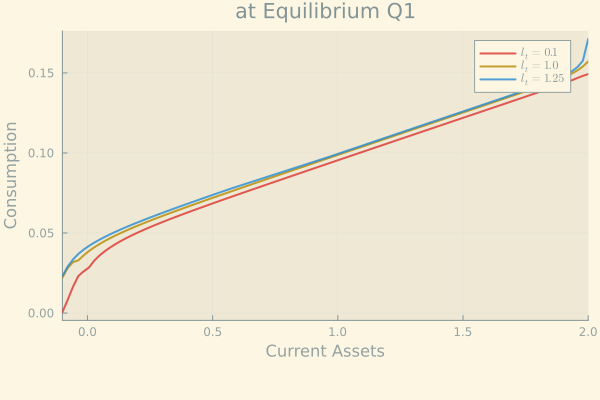

In [54]:
p_eq1 = HouseholdProblem(r = eq_sol_13[1] 
        , w = eq_sol_13[2] ) # behaviour of the consumer at optimum

initial_v = ones(p_eq1.a_size, p_eq1.z_size); #An initial guess -- fairly arbitrary
sol_eq1 = solve_household_T2(initial_v, p = p_eq1); 

con_plot_1 = plot(xlim = (extrema(p_eq1.a_vals)), title = "at Equilibrium Q1", xlabel="Current Assets", ylabel="Consumption")
for (i,z_val) in enumerate(p_eq1.z_vals)
        plot!(con_plot_1, p_eq1.a_vals, sol_eq1.c[:,i], linewidth = 2, alpha = 0.8, label = L"l_t=%$z_val", bottom_margin= 10Plots.mm )
end 
@show(con_plot_1)

assets_plt_1 = Plot{Plots.GRBackend() n=3}


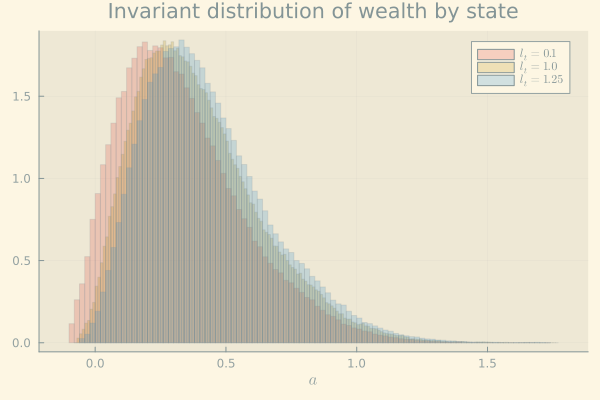

In [55]:
# Note: We normalize the assets series to a discrete PDF, where the total area of the bins is 1.
a_serie, idxz = compute_asset_series(p_for_assets = p_eq1, sol = sol_eq1, init_cond=1,T_N = 500_000)

storeStVal_1 = [a_serie idxz]
assets_plt_1 = plot(title = "Invariant distribution of wealth by state", bottom_margin= 2Plots.mm )
for (i, z_val) in enumerate(p_eq1.z_vals)
    filtered = storeStVal_1[(storeStVal_1[:,2] .== i),1];
    histogram!(assets_plt_1,filtered, leg = true, 
        normed = true, xlabel = L"a", alpha = 0.2, label = L"l_t=%$z_val")
end 
@show(assets_plt_1)

### Q2: 
Keep all other parameters as before, but now set $\underline{a} = 0$. Compute the equilibrium $r$ and $w$, and plot the invariant wealth distribution and consumption function. Provide an economic explanation for the changes in outcome.

> Note: We are going to responde this question in other section. 

In [56]:
p_initial = HouseholdProblem(a_low = 1e-10)

f_initial = firmProblem()

eq_sol_23 = market_equilibrium3(p_market=p_initial, f_market=f_initial, 
low_r = 0.02, high_r = 0.07);

con_plot_2 = Plot{Plots.GRBackend() n=3}


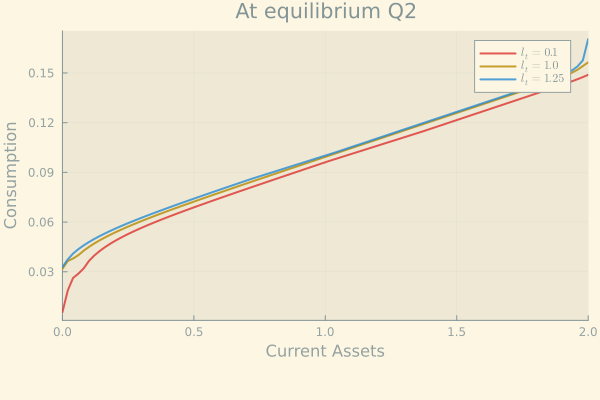

In [57]:
p_eq2 = HouseholdProblem(a_low = 1e-10, r = eq_sol_23[1]
        , w = eq_sol_23[2]) # behaviour of the consumer at optimum

initial_v = ones(p_eq2.a_size, p_eq2.z_size); #An initial guess -- fairly arbitrary
sol_eq2 = solve_household_T2(initial_v, p = p_eq2); 

con_plot_2 = plot(xlim = (extrema(p_eq2.a_vals)))
for (i,z_val) in enumerate(p_eq2.z_vals)
        plot!(con_plot_2, p_eq2.a_vals, sol_eq2.c[:,i], linewidth = 2, alpha = 0.8, label = L"l_t=%$z_val", bottom_margin= 10Plots.mm
                ,title = "At equilibrium Q2", xlabel="Current Assets", ylabel="Consumption" )
end 
@show(con_plot_2)

assets_plt_2 = Plot{Plots.GRBackend() n=3}


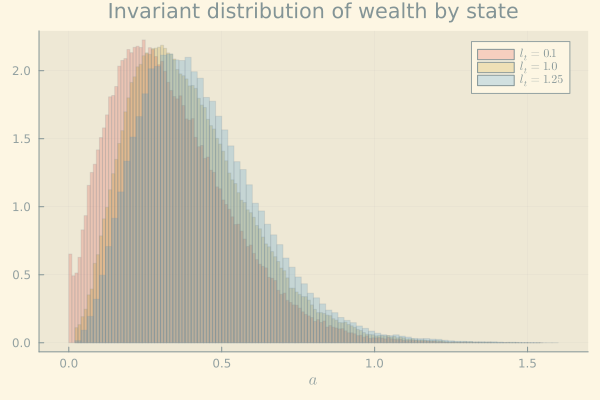

In [58]:
# We normalize the assets series to a discrete PDF, where the total area of the bins is 1.
a_serie, idxz = compute_asset_series(p_for_assets = p_eq2, sol = sol_eq2, init_cond=1, T_N = 500_000)

storeStVal_2 = [a_serie idxz]

assets_plt_2 = plot(title = "Invariant distribution of wealth by state", bottom_margin= 2Plots.mm )
for (i, z_val) in enumerate(p_eq2.z_vals)
    filtered = storeStVal_2[(storeStVal_2[:,2] .== i),1];
    histogram!(assets_plt_2,filtered, leg = true, 
        normed = true, xlabel = L"a", alpha = 0.2, label = L"l_t=%$z_val")
end 
@show(assets_plt_2)

### Q3:
 Keep all other parameters as in Question 1 (i.e., $\underline{a} = 0.1$), but use a new transition matrix $$ \Pi_2 = \begin{bmatrix} 0.6 & 0.4 & 0 \\ 0.1 & 0.85 & 0.05 \\ 0 & 0.1 & 0.9 \end{bmatrix}.$$  Compute the equilibrium $r$ and $w$, and plot the invariant wealth distribution and consumption function. Provide an economic explanation for the changes in outcome.

> Note: We are going to responde this question in other section. 

In [59]:
Π_2 = [0.6 0.4 0 ; 0.1 0.85 0.05; 0 0.1 0.9]
p_initial = HouseholdProblem(Π = Π_2)
f_initial = firmProblem()

eq_sol_33 = market_equilibrium3(p_market=p_initial, f_market=f_initial, 
low_r = 0.02, high_r = 0.07);

con_plot_3 = Plot{Plots.GRBackend() n=3}


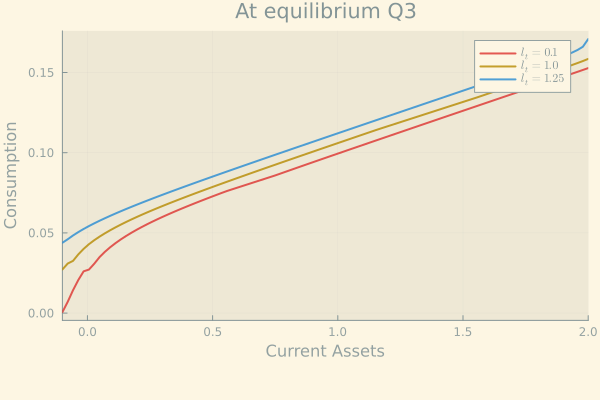

In [60]:
p_eq3 = HouseholdProblem(Π = Π_2, r = eq_sol_33[1] 
        , w = eq_sol_33[2]) # behaviour of the consumer at optimum

initial_v = ones(p_eq3.a_size, p_eq3.z_size); #An initial guess -- fairly arbitrary
sol_eq3 = solve_household_T2(initial_v, p = p_eq3); 

con_plot_3 = plot(xlim = (extrema(p_eq3.a_vals)))
for (i,z_val) in enumerate(p_eq3.z_vals)
        plot!(con_plot_3, p_eq3.a_vals, sol_eq3.c[:,i], linewidth = 2, alpha = 0.8, label = L"l_t=%$z_val", bottom_margin= 10Plots.mm
                ,title = "At equilibrium Q3", xlabel="Current Assets", ylabel="Consumption" )
end 
@show(con_plot_3)

assets_plt_3 = Plot{Plots.GRBackend() n=3}


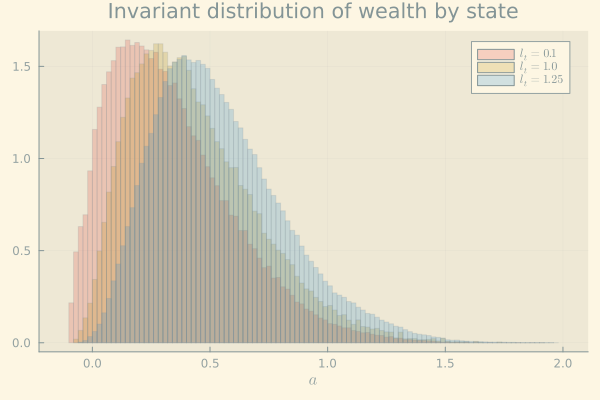

In [61]:
# We normalize the assets series to a discrete PDF, where the total area of the bins is 1.
a_serie, idxz = compute_asset_series(p_for_assets = p_eq3, sol = sol_eq3, init_cond=1, T_N = 500_000)

storeStVal_3 = [a_serie idxz]

assets_plt_3 = plot(title = "Invariant distribution of wealth by state", bottom_margin= 2Plots.mm )
for (i, z_val) in enumerate(p_eq3.z_vals)
    filtered = storeStVal_3[(storeStVal_3[:,2] .== i),1];
    histogram!(assets_plt_3,filtered, leg = true, 
        normed = true, xlabel = L"a", alpha = 0.2, label = L"l_t=%$z_val")
end 
@show(assets_plt_3)

## Response to questions: Q2 and Q3

Economic Explanation: 
1. Q1 vs Q2 : 
    - Effect over the policy function of consumption: Comparing the setting of Q2 with our benchmark in Q1, we have that the only difference is at the interval $a\in[-0.1,0]$. This difference only occurs because we did not simulate the values of our optimal policie for that sector in Q2, however intuitively we can think that the optimal values of consumption need to be lower than the optimal values that we have in Q1 because in Q1 we can finance our consumption using borrowing. 
    
    - Effect over the invariant distribution of wealth: Comparing the setting of Q2 with our benchmark in Q1, we have that the stationary wealth distributions are almost the same. The only difference is that we do not see wealth values at $a\in[-0.1,0]$ (by construction). The latter occurs because we have the same policies for both problems in the interval $a\geq 0$ but in Q2 we started the asset grid from $0$.
2. Q1 vs Q3:  
    - Effect over the invariant distribution of wealth: Comparing the setting of Q3 with our benchmark in Q1, we have that the stationary wealth distributions is shifted to the right, its have a greater mean and median than Q1 and a fatter right tail than Q1. The latter occurs because in Q3, 1. when you achieve $l_t=1.25$ the probability of remaining in this state is greater than in Q1 and the probability of going from this state to $l_t=0.1$ is $0$; 2. when you are in $l_t=1$ the probability of remaining in this state is greater than in Q2. In other words, the expected income of a particular individual is greater than in the case of the benchmark, because of that we see a greater asset accumulation.  
    
    - Effect over the policy function of consumption: Comparing the setting of Q3 with our benchmark in Q1, we see that the optimal comsumption $c^*(a,l)$ is greater than the optimal in our benchmark for any given state and asset. This difference occurs because the expected income of a particular individual is greater than in our benchmark, because of that we see a greater consumption in any given period and state.  

In [62]:
# Results from before
println("Equilibrium values for Q1: r= $(eq_sol_13[1]); w=$(eq_sol_13[2])")
println("Equilibrium values for Q2: r= $(eq_sol_23[1]); w=$(eq_sol_23[2])")
println("Equilibrium values for Q3: r= $(eq_sol_33[1]); w=$(eq_sol_33[2])")

Equilibrium values for Q1: r= 0.050606047598220294; w=0.05594709495413342
Equilibrium values for Q2: r= 0.05012368169558307; w=0.056177209791429636
Equilibrium values for Q3: r= 0.050378827576495755; w=0.0560550991449641


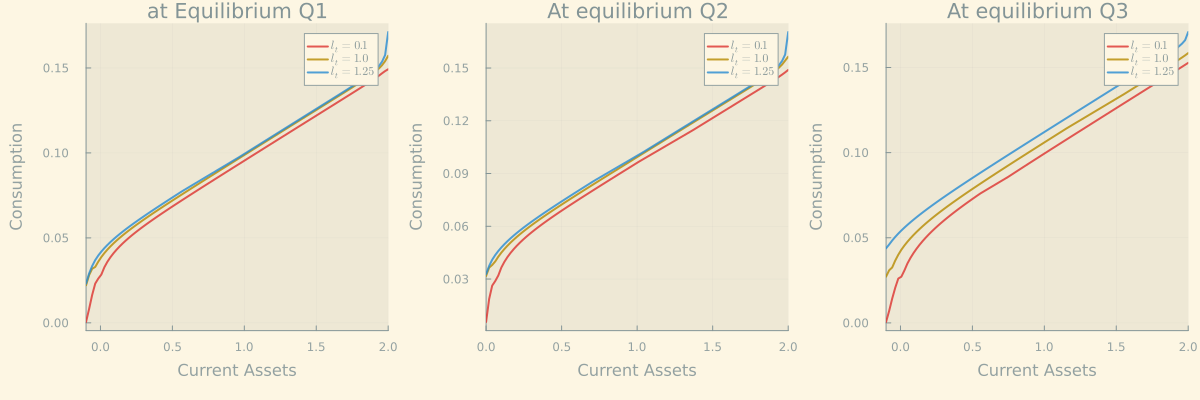

In [63]:
plot(con_plot_1, con_plot_2, con_plot_3;layout=(1,3),size=(1200,400),bottom_margin= 10Plots.mm, left_margin= 7Plots.mm)

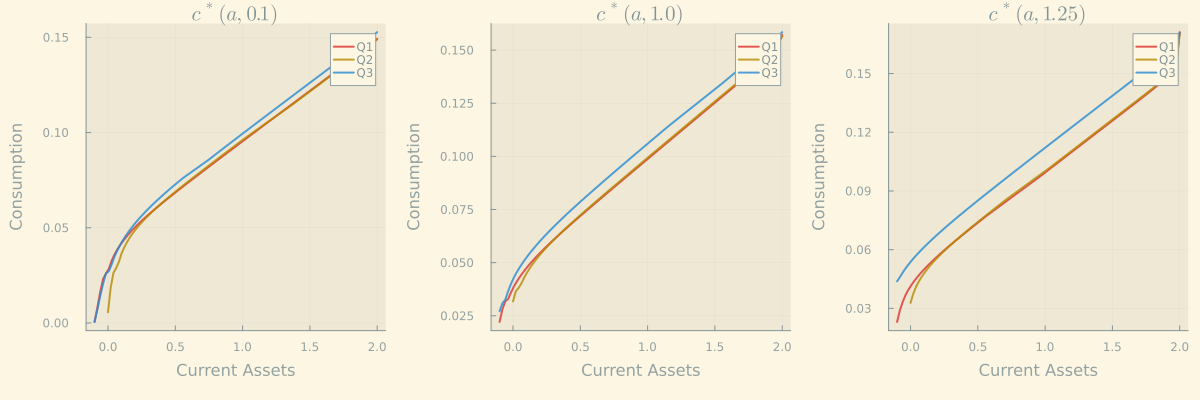

In [64]:
storePlotCons = Any[]
for (i, z_val) in enumerate(p_eq3.z_vals)
    Con_plt_all = plot(title = L"c^*(a,%$z_val) ")

    plot!(p_eq1.a_vals, sol_eq1.c[:,i], linewidth = 2, alpha = 0.8, label = "Q1", bottom_margin= 10Plots.mm
                , xlabel="Current Assets", ylabel="Consumption" )

    plot!(p_eq2.a_vals, sol_eq2.c[:,i], linewidth = 2, alpha = 0.8, label = "Q2", bottom_margin= 10Plots.mm
                , xlabel="Current Assets", ylabel="Consumption" )

    plot!(p_eq3.a_vals, sol_eq3.c[:,i], linewidth = 2, alpha = 0.8, label = "Q3", bottom_margin= 10Plots.mm
                , xlabel="Current Assets", ylabel="Consumption" )
    push!(storePlotCons, Con_plt_all)
end 
plt = plot(storePlotCons...,layout=(1,3),size=(1200,400),bottom_margin= 10Plots.mm, left_margin= 7Plots.mm)

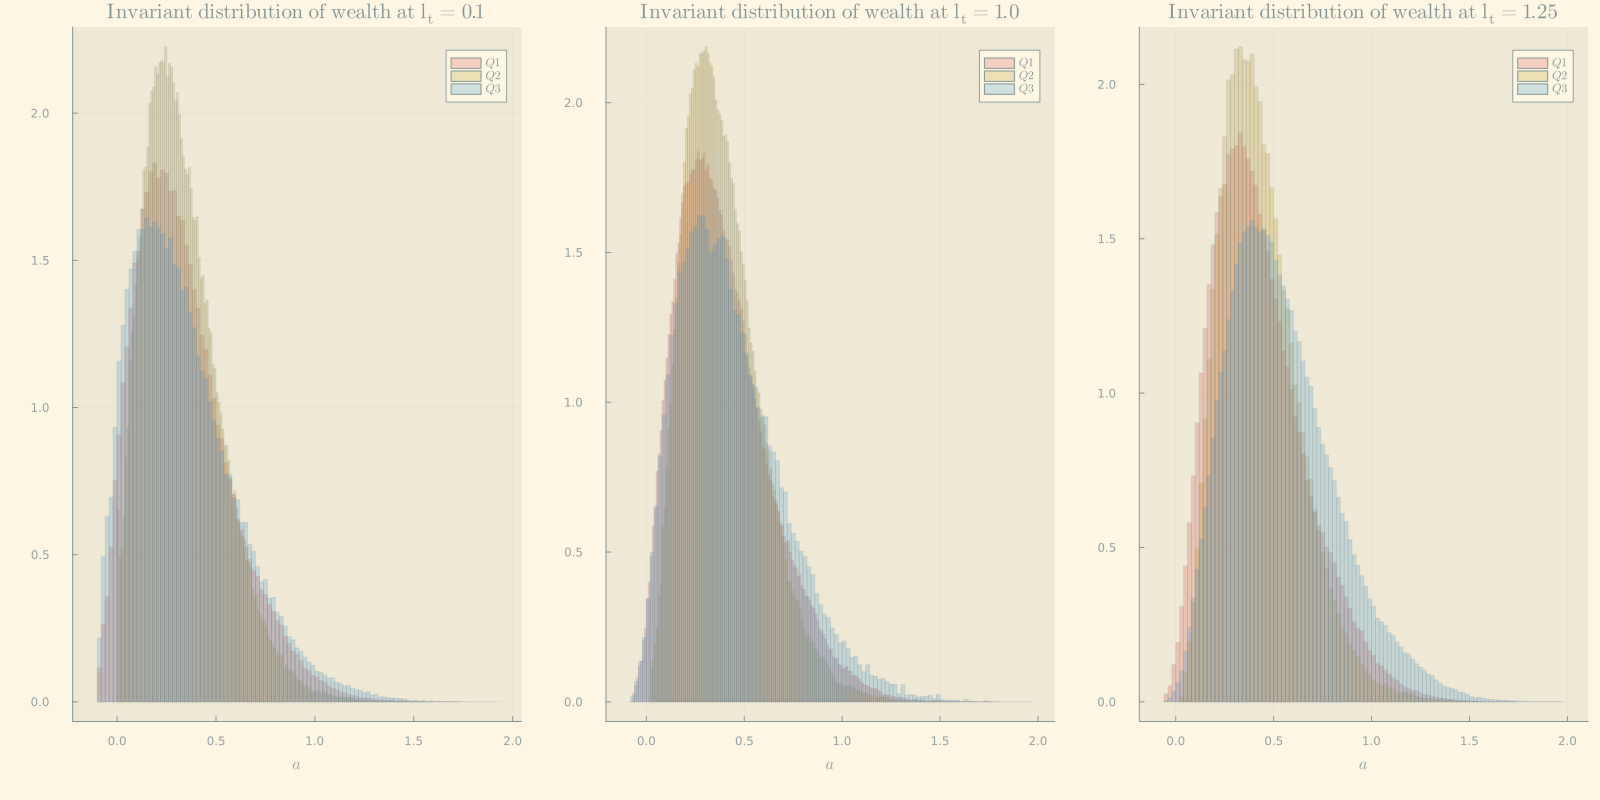

In [65]:
# Plot of the invariant distributions given a particular state. We normalize the assets series to a discrete PDF, where the total area of the bins is 1.
storePlot = Any[]
for (i, z_val) in enumerate(p_eq2.z_vals)
    assets_plt_all = plot(title = L"\mathrm{Invariant\  distribution\  of\ wealth\ at\ l_t=%$z_val} ", bottom_margin= 2Plots.mm )

    filtered = storeStVal_1[(storeStVal_1[:,2] .== i),1];
    histogram!(assets_plt_all,filtered, leg = true, 
        normed = true, xlabel = L"a", alpha = 0.2, label = L"Q1")

    filtered = storeStVal_2[(storeStVal_2[:,2] .== i),1];
    histogram!(assets_plt_all,filtered, leg = true, 
        normed = true, xlabel = L"a", alpha = 0.2, label = L"Q2")
    
    filtered = storeStVal_3[(storeStVal_3[:,2] .== i),1];
    histogram!(assets_plt_all,filtered, leg = true, 
        normed = true, xlabel = L"a", alpha = 0.2, label = L"Q3")

    push!(storePlot, assets_plt_all)
end 
plt = plot(storePlot...,layout=(1,3),size=(1600,800),bottom_margin= 10Plots.mm, left_margin= 7Plots.mm)

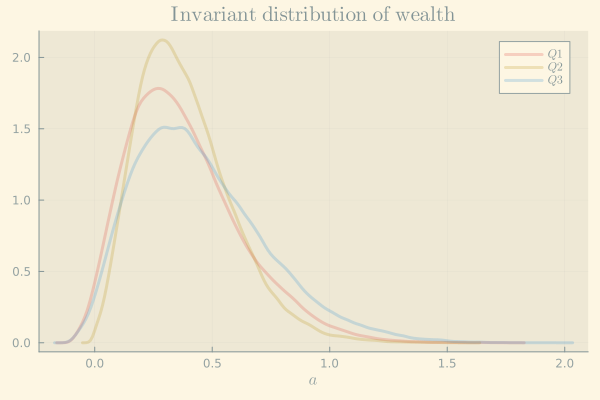

In [66]:
# Plot of the invariant distributions given a particular state. 
using StatsPlots 
storePlot = Any[]

assets_plt_all = plot(title = L"\mathrm{Invariant\  distribution\  of\ wealth} ", bottom_margin= 2Plots.mm )

density!(storeStVal_1[:,1], xlabel = L"a", alpha = 0.2, label = L"Q1",linewidth = 3)
density!(storeStVal_2[:,1], xlabel = L"a", alpha = 0.2, label = L"Q2",linewidth = 3)
density!(storeStVal_3[:,1], xlabel = L"a", alpha = 0.2, label = L"Q3",linewidth = 3)


### Q4 
Now, we will use all the parameter values as in Question 1 (i.e., $\Pi$ not $\Pi_2$), but will consider a mean-preserving spread of the $l$ process in the invariant distribution. Now, $l_t \in \{0.07, 1, 1.25+\mu\}$. Compute the $\mu$ that makes this a mean-preserving spread. Compute the equilibrium $r$ and $w$, and plot the invariant wealth distribution and consumption function. Provide an economic explanation for the changes in outcome.

In [67]:
function μ_star(μ, mean_eq1, sol_eq1,a_serie_eq1)
    f_initial = firmProblem()
    p_initial = HouseholdProblem(z_vals = [0.07; 1; 1.25 + μ ])
    eq_sol_43 = market_equilibrium3(p_market=p_initial, f_market=f_initial, 
        low_r = 0.02, high_r = 0.07);

    p_eq4 = HouseholdProblem(z_vals = [0.07; 1; 1.25 + μ ], 
            r = eq_sol_43[1], w = eq_sol_43[2]) 

    initial_v = ones(p_eq4.a_size, p_eq4.z_size); #An initial guess -- fairly arbitrary
    sol_eq4 = solve_household_T2(initial_v, p = p_eq4); 

    a_serie, idxz = compute_asset_series(p_for_assets = p_eq4, sol = sol_eq4, init_cond=1, T_N = 500_000)

    storeStVal_4 = [a_serie idxz]

    gcdf_1 = ecdf(a_serie_eq1)
    gcdf_4 = ecdf(storeStVal_4[:, 1])

    vals_01 = gcdf_1(range(extrema(a_serie_eq1)[1], extrema(a_serie_eq1)[2], length = 20 ))
    vals_04 = gcdf_4(range(extrema(storeStVal_4[:, 1])[1], extrema(storeStVal_4[:, 1])[2], length = 20 ))

    if all(cumsum(vals_04[2:end-1]) .> cumsum(vals_01[2:end-1])) 
        return mean(storeStVal_4[:, 1]) - mean(a_serie_eq1)
    else 
        return 10_000
    end 
end 

low_μ = 0.01
high_μ = 0.7
mean_eq1 = mean(storeStVal_1[:,1])

#=
storeValues_mu = zeros(100,2)
for (i,μ) ∈ enumerate(range(low_μ, high_μ, 100))
    storeValues_mu[i,1] = μ_star(μ, mean_eq1, sol_eq1, storeStVal_1[:,1]) 
    storeValues_mu[i,2] = μ 
end 

mu_star = storeValues_mu[argmin(storeValues_mu[:,1]),2]
=#

#mu_star = brent(μ->μ_star(μ, mean_eq1, sol_eq1, storeStVal_1[:,1]), low_μ,high_μ)
mu_star = 0.03 #do it by hand
#println([mu_star])

0.03

In [68]:
p_initial = HouseholdProblem(z_vals = [0.07; 1; 1.25 + mu_star ])
eq_sol_43 = market_equilibrium3(p_market=p_initial, f_market=f_initial, 
        low_r = 0.02, high_r = 0.07);

p_eq4 = HouseholdProblem(z_vals = [0.07; 1; 1.25 + mu_star], 
            r = eq_sol_43[1], w = eq_sol_43[2]) 

initial_v = ones(p_eq4.a_size, p_eq4.z_size); #An initial guess -- fairly arbitrary
sol_eq4 = solve_household_T2(initial_v, p = p_eq4); 

con_plot_4 = Plot{Plots.GRBackend() n=3}


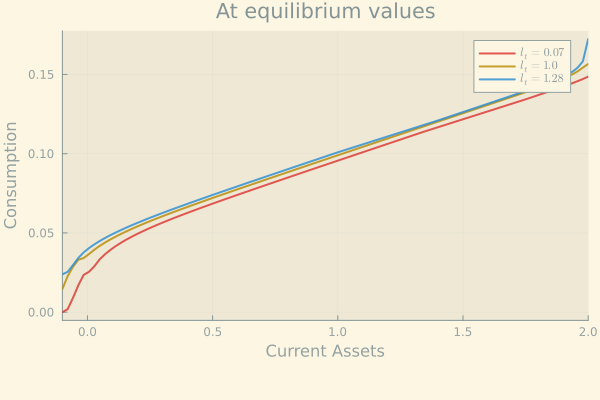

In [69]:
con_plot_4 = plot(xlim = (extrema(p_eq4.a_vals)))
for (i,z_val) in enumerate(p_eq4.z_vals)
        temp = round(z_val, digits = 3 )
        plot!(con_plot_4, p_eq4.a_vals, sol_eq4.c[:,i], linewidth = 2, alpha = 0.8, label = L"l_t=%$temp", bottom_margin= 10Plots.mm
                ,title = "At equilibrium values", xlabel="Current Assets", ylabel="Consumption" )
end 
@show(con_plot_4)

assets_plt_4 = Plot{Plots.GRBackend() n=3}


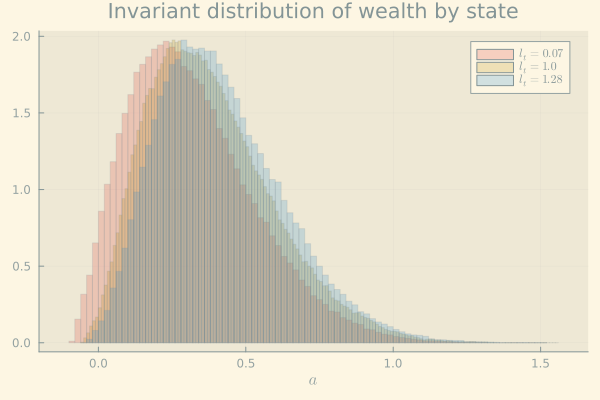

In [70]:

a_serie, idxz = compute_asset_series(p_for_assets = p_eq4, sol = sol_eq4, init_cond=1, T_N = 500_000)
storeStVal_4 = [a_serie idxz]

assets_plt_4 = plot(title = "Invariant distribution of wealth by state", bottom_margin= 2Plots.mm )
for (i, z_val) in enumerate(p_eq4.z_vals)
    temp = round(z_val, digits = 3 )
    filtered = storeStVal_4[(storeStVal_4[:,2] .== i),1];
    histogram!(assets_plt_4,filtered, leg = true, 
        normed = true, xlabel = L"a", alpha = 0.2, label = L"l_t=%$temp")
end 
@show(assets_plt_4)

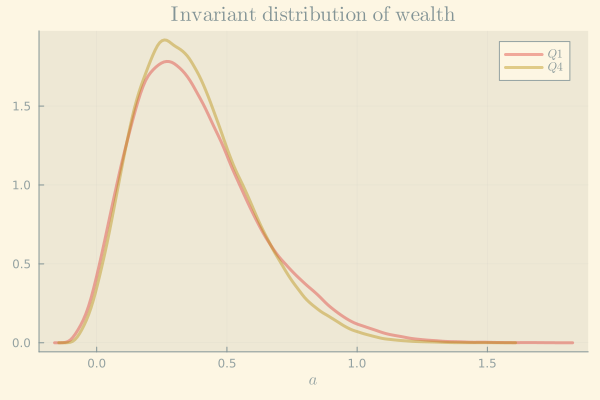

In [71]:
assets_plt_all2 = plot(title = L"\mathrm{Invariant\  distribution\  of\ wealth }", bottom_margin= 2Plots.mm )

density!(storeStVal_1[:,1], xlabel = L"a", alpha = 0.4, label = L"Q1",linewidth = 3)
density!(storeStVal_4[:,1], xlabel = L"a", alpha = 0.4, label = L"Q4",linewidth = 3)

Because the distribution now is more riskier than in out benchmark but preserve the mean, we see that the invariant distribution of wealth is greater in the middle and lower in the right tail of the distribution than the distribution that we can see in Q1. 

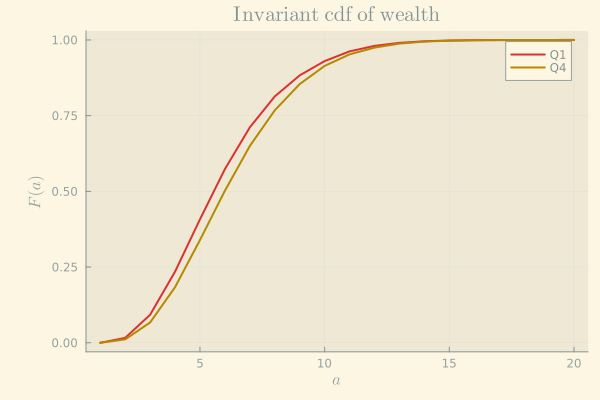

In [72]:
gcdf_1 = ecdf(storeStVal_1[:,1])
gcdf_4 = ecdf(storeStVal_4[:, 1])

vals_01 = gcdf_1(range(extrema(storeStVal_1[:, 1])[1], extrema(storeStVal_1[:, 1])[2], length = 20 ))
vals_04 = gcdf_4(range(extrema(storeStVal_4[:, 1])[1], extrema(storeStVal_4[:, 1])[2], length = 20 ))

sosd = plot(title = L"\mathrm{Invariant\  cdf \  of\ wealth }", bottom_margin= 2Plots.mm )
plot!(sosd, vals_01, label = "Q1", linewidth=2)
plot!(sosd, vals_04, label = "Q4", linewidth=2)
plot!(sosd, xlabel = L"a", ylabel=L"F(a)",  left_margin= 7Plots.mm)

From here we can see that the $F(a)$ of Q4 is a mean-preserving spread of $F(a)$ of Q1

In [73]:

println("Equilibrium values for Q1: r= $(eq_sol_13[1]); w=$(eq_sol_13[2])")
println("Equilibrium values for Q4: r= $(eq_sol_33[1]); w=$(eq_sol_33[2])")

println("Mean assets in Q1: $(mean(storeStVal_1[:,1])); Mean assets in Q4: $(mean(storeStVal_4[:,1]))" )
println("Std. assets in Q1: $(std(storeStVal_1[:,1])); Std. assets in Q4: $(std(storeStVal_4[:,1]))" )

Equilibrium values for Q1: r= 0.050606047598220294; w=0.05594709495413342
Equilibrium values for Q4: r= 0.050378827576495755; w=0.0560550991449641
Mean assets in Q1: 0.38257093268599607; Mean assets in Q4: 0.3691602463846748
Std. assets in Q1: 0.24172501132231106; Std. assets in Q4: 0.2163078564465374


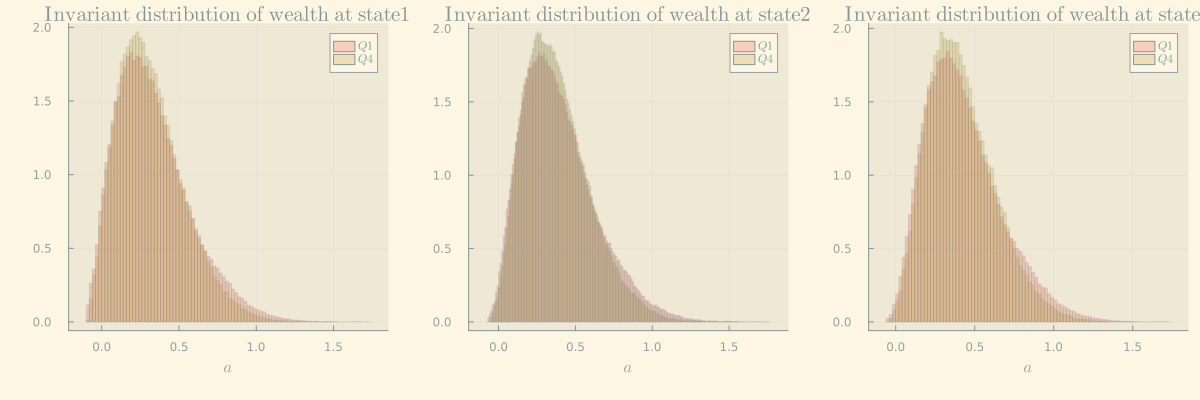

In [74]:
# Plot of the invariant distributions given a particular state. We normalize the assets series to a discrete PDF, where the total area of the bins is 1.
storePlot = Any[]
for (i, z_val) in enumerate(p_eq2.z_vals)
    assets_plt_all = plot(title = L"\mathrm{Invariant\  distribution\  of\ wealth\ at\ state %$i }", bottom_margin= 2Plots.mm )

    filtered = storeStVal_1[(storeStVal_1[:,2] .== i),1];
    histogram!(assets_plt_all,filtered, leg = true, 
        normed = true, xlabel = L"a", alpha = 0.2, label = L"Q1")
    
    filtered = storeStVal_4[(storeStVal_4[:,2] .== i),1];
    histogram!(assets_plt_all,filtered, leg = true, 
        normed = true, xlabel = L"a", alpha = 0.2, label = L"Q4")

    push!(storePlot, assets_plt_all)
end 
plot(storePlot...,layout=(1,3),size=(1200,400),bottom_margin= 10Plots.mm, left_margin= 7Plots.mm)

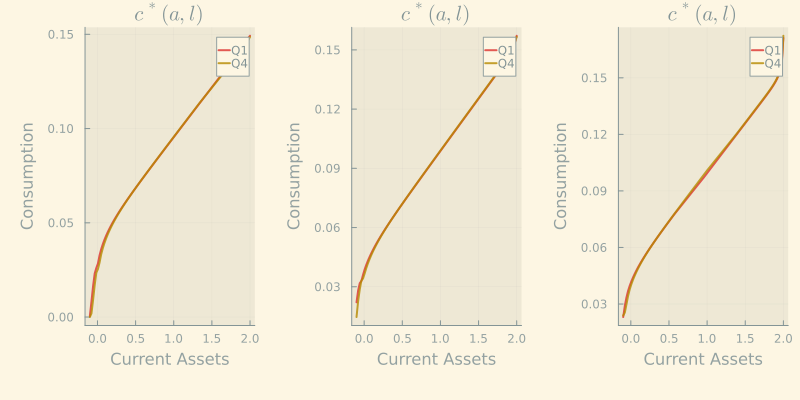

In [75]:
storePlotCons = Any[]
for (i, z_val) in enumerate(p_eq3.z_vals)
    Con_plt_all = plot(title = L"c^*(a,l)")

    plot!(p_eq1.a_vals, sol_eq1.c[:,i], linewidth = 2, alpha = 0.8, label = "Q1", bottom_margin= 10Plots.mm
                , xlabel="Current Assets", ylabel="Consumption" )


    plot!(p_eq4.a_vals, sol_eq4.c[:,i], linewidth = 2, alpha = 0.8, label = "Q4", bottom_margin= 10Plots.mm
                , xlabel="Current Assets", ylabel="Consumption" )
    push!(storePlotCons, Con_plt_all)
end 
plt = plot(storePlotCons...,layout=(1,3),size=(800,400),bottom_margin= 10Plots.mm, left_margin= 7Plots.mm)

Because the distribution now is more riskier than in out benchmark, we see that the policy for the optimal consumption in Q4 is going to have low values of consumption at every point of $a$. However, the difference is little because a mean preserving spread produce a second order effect over consumption. 